In [49]:
%matplotlib notebook
%pylab inline
import gzip
import json
import os
import pickle
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch

from collections import Counter, namedtuple

from gensim.models import KeyedVectors
from linear_model import BayesianLinearModel
from nltk.corpus import stopwords
from scipy.stats import kendalltau, pearsonr, spearmanr, zscore
from sklearn.metrics import cohen_kappa_score
from sklearn.preprocessing import PolynomialFeatures
from torch.autograd import Variable

from ptcap.data.tokenizer import Tokenizer
from ptcap.scores import (LCS, caption_accuracy, first_token_accuracy, fscore,
                          gmeasure, token_accuracy)
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.metrics import MultiScorer
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.spice.spice import Spice

import os

import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [63]:
correlation_metrics = {"Kappa": cohen_kappa_score, "Pearson": pearsonr,
                       "Kendall": kendalltau, "Spearman": spearmanr}

stop_words = ['A', 'AN', 'THE']

def get_correlations(x, y, corr_score_dict):
    corr_dict = {}
    if isinstance(x, dict):
        for metric in x:
            corr_dict[metric] = {}
            for name, corr in corr_score_dict.items():
                if "Kappa" not in name:
                    corr_dict[metric][name] = corr(x[metric], y)[0]
    elif isinstance(x, list):
        for name, corr in corr_score_dict.items():
            if "Kappa" not in name:
                corr_dict[name] = corr(x, y)[0]
    return corr_dict


def get_encodings(accuracies, caption, prediction, tokenizer, score_attr):
    encoded_caption = Variable(
        torch.LongTensor([tokenizer.encode_caption(caption)]))
    encoded_prediction = Variable(
        torch.LongTensor([tokenizer.encode_caption(prediction)]))
    in_tuple = score_attr([caption], encoded_caption, encoded_prediction)
    lcs_output = accuracies["LCS"](in_tuple)

    accuracy_dict = {name: [value(in_tuple)[name]] for name, value in
                  accuracies.items()
                  if name is not "LCS"}
    accuracy_dict.update({name: [value] for name, value in lcs_output.items()})
    return accuracy_dict


def get_wmd(model, caption, prediction):
    from nltk.corpus import stopwords
    stop_words = stopwords.words('english')
    cap = [w for w in caption.split() if (w in model and w not in stop_words)]
    pred = [w for w in prediction.split() if (w in model and w not in stop_words)]
    wmd = model.wmdistance(cap, pred)
    return {"wmd": [wmd]}


def scatter_plot(x, y, xlabel="x-axis", ylabel="y-axis", powers=None):
    if powers is None:
        powers = [1, 3, 7]
    agg_all = Counter(zip(x, y))
    z = []
    for x_, y_ in zip(x, y):
        z.append(agg_all[x_, y_])

    plt.scatter(x, y, s=z, alpha=0.5)
    for p in powers:
        plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, p))(np.unique(x)), label=str(p))
#     plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 7))(np.unique(x)), label="Septic")
#     plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 3))(np.unique(x)), label="Cubic")
#     plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 10))(np.unique(x)), label="Decic")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='upper left')
#     plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
    plt.rcParams['figure.figsize'] = (5,5)
    plt.show()
    
    
def split_into_bins(final_score, k):
    bins = {}

    min_val = np.min(final_score)

    diff = (np.max(final_score) - min_val) / k

    for i, score in enumerate(final_score):
        for j in range(k):
            if score <= min_val + (j + 1) * diff:
                if "bin_" + str(j + 1) in bins:
                    bins["bin_" + str(j + 1)].append(i)
                else:
                    bins["bin_" + str(j + 1)] = [i]
                break
    return bins


def try_metrics(captions, predictions):

    print("Loading Word Vectors...")
    a = time.time()
    model = KeyedVectors.load_word2vec_format(
        '/home/waseem/Models/GoogleNews-vectors-negative300.bin', binary=True)
    b = time.time()
    print("Word Vectors loaded in {}".format(b - a))

    tokenizer = Tokenizer()
    tokenizer.load_dictionaries("/home/waseem/Models/")

    accuracies = {"caption_accuracy": caption_accuracy,
                  "first_accuracy": first_token_accuracy,
                  "accuracy": token_accuracy,
                  "LCS": LCS([fscore, gmeasure], tokenizer)}

    ScoreAttr = namedtuple("ScoresAttr", "string_captions captions predictions")
    multi_scorer = MultiScorer(BLEU=Bleu(4), ROUGE_L=Rouge(), METEOR=Meteor(),
                               SPICE=Spice())

    output_dict = {}

    a = time.time()
    
    counter = 0

    for caption, prediction in zip(captions, predictions):

        encodings = get_encodings(accuracies, caption, prediction, tokenizer,
                                  ScoreAttr)
        output_val = encodings

        multi_scores = multi_scorer.score((caption,), [prediction])
        output_val.update({key: [value] for key, value in multi_scores.items()})

        wmd = get_wmd(model, caption, prediction)
        output_val.update(wmd)

        if output_dict == {}:
            output_dict = output_val
        else:
            update_dict(output_dict, output_val)
            # with open("/home/waseem/Metrics Analysis/metric_values", "w") as f:
            #     json.dump(output_dict, f)
            
        counter += 1
        
        print("Taken care of {} pairs".format(counter))

    b = time.time()

    print("try_metrics took {}".format(b - a))

    # with open("/home/waseem/Metrics Analysis/metric_values", "w") as f:
    #     json.dump(output_dict, f)

    return output_dict

In [3]:
NUM = 0
LINES = 11
PATH = "/home/waseem/Downloads/Caption_Evaluation_"


def get_annotations(csv_file):
    annotations = {"s1": [], "s2": [], "action": [], "object": []}
    for line in csv_file.itertuples():
        col3, col4 = preprocess(line[3], line[4])
        annotations["s1"].append(line[1])
        annotations["s2"].append(line[2])
        annotations["action"].append(col3)
        annotations["object"].append(col4)
    return annotations


def get_file_info():
    global_dict = {"action": [], "object": []}
    author1_dict = {"action": [], "object": []}
    author2_dict = {"action": [], "object": []}
    sentences = {"s1": [], "s2": []}
    metric_scores = {metric_name: {} for metric_name in correlation_metrics}
    for i in range(1, 11):

        # if i == 9 or i == 3:
        #     continue

        author1 = parse_file("1", i)
        if author1 == -1:
            print("No annotations by author1")
            continue
        else:
            update_dict(global_dict, author1)
            update_dict(author1_dict, author1)
            update_dict(sentences, author1)

        author2 = parse_file("2", i)
        if author2 == -1:
            print("No annotations by author2")
            continue
        else:
            update_dict(global_dict, author2)
            update_dict(author2_dict, author2)

        for category in global_dict.keys():
#             print("For " + str(i) + " - " + category)
            for metric_name, metric in correlation_metrics.items():
                score = metric(author1[category], author2[category])
                try:
                    unit = score[0]
                except IndexError:
                    unit = score
                if category + str(i) not in metric_scores[metric_name]:
                    metric_scores[metric_name][category + str(i)] = [unit]
                else:
                    metric_scores[metric_name][category + str(i)].append(unit)
            current_scores = {metric_name: metric_scores[metric_name][category + str(i)][0]
                              for metric_name in metric_scores.keys()}
#             print("The scores between author1 and author2 is {}".format(
#                   current_scores))
    return sentences, global_dict, author1_dict, author2_dict


def parse_file(folder_num, index):
    path = os.path.join(PATH + folder_num, str(index) + ".csv")
    if os.path.exists(path):
        csv_file = pd.read_csv(path, header=None)
        annotations = get_annotations(csv_file[11:])
        return annotations
    return -1


def preprocess(str_num1, str_num2):
    num1 = float(str_num1)
    num2 = float(str_num2)
    if num1 == 0.5:
        num1 = 1.0
    if num1 == 1.5:
        num1 = 2.0
    if num2 == 0.5:
        num2 = 0.0
    if num2 == 1.5:
        num2 = 1.0
    if num2 == 3:
        num2 = 2.0
    if num2 == 4:
        num2 = 5.0
    if num2 == 5.0:
        num2 = 3.0
    return num1, num2

def update_dict(global_dict, author):
    for category, scores in author.items():
        if category in global_dict:
            if isinstance(scores, list):
                global_dict[category].extend(scores)
            elif isinstance(scores, float):
                global_dict[category].append(scores)
            else:
                raise NotImplemented

In [4]:
class AnnotationParser(object):

    def __init__(self, annot_path, video_root,
                 file_path="file", caption_type="template"):
        self.video_root = video_root
        self.file_path = file_path
        self.caption_type = caption_type
        self.annotations = self.open_annotation(annot_path)

    @classmethod
    def open_annotation(cls, path):
        pass

    def get_video_paths(self):
        files = self.annotations[self.file_path]
        return [os.path.join(self.video_root, name.split("/")[0])
                for name in files]

    def get_captions(self):
        return [p for p in self.annotations[self.caption_type]]


class JsonParser(AnnotationParser):

    @classmethod
    def open_annotation(cls, path):
        if path.endswith("gz"):
            with gzip.open(path, "rb") as f:
                json = pd.read_json(f.read().decode("utf-8"))
        else:
            json = pd.read_json(path)
        return json

In [5]:
with open("/home/waseem/Metrics Analysis/author_based", "rb") as f:
    (author1_metric, author2_metric, final_actions, final_objects,
     final_score) = pickle.load(f)

with open("/home/waseem/Metrics Analysis/metric_values", "r") as f:
    output_dict = json.load(f)

In [6]:
annotations = JsonParser.open_annotation("/data/20bn-somethingsomething/json/train_20171031.json.gz")
templates = np.unique(annotations["template"]) # A list of templates

In [7]:
get_correlations(output_dict, final_score, correlation_metrics)

/home/waseem/venvs/ptcap/lib/python3.5/site-packages/scipy/stats/stats.py:3000: RuntimeWarning: invalid value encountered in subtract
  xm, ym = x - mx, y - my


{'BLEU@1': {'Kendall': 0.55563676525871253,
  'Pearson': 0.77521586768480677,
  'Spearman': 0.71833093310953466},
 'BLEU@2': {'Kendall': 0.54177550147942888,
  'Pearson': 0.68811677281432748,
  'Spearman': 0.70808850655946853},
 'BLEU@3': {'Kendall': 0.53424978458287231,
  'Pearson': 0.5784785022415021,
  'Spearman': 0.70306469994190679},
 'BLEU@4': {'Kendall': 0.52383687929876699,
  'Pearson': 0.50096417265949089,
  'Spearman': 0.69077286998381537},
 'METEOR': {'Kendall': 0.63213079222977586,
  'Pearson': 0.76428164493087747,
  'Spearman': 0.78563115822218921},
 'ROUGE_L': {'Kendall': 0.59655230537420567,
  'Pearson': 0.79532767722388875,
  'Spearman': 0.74648976149162904},
 'SPICE': {'Kendall': 0.52754236844544711,
  'Pearson': 0.71216155110685364,
  'Spearman': 0.60518153424201115},
 'accuracy': {'Kendall': 0.27625869649764651,
  'Pearson': 0.45005718652597027,
  'Spearman': 0.36746707525081174},
 'caption_accuracy': {'Kendall': 0.24123701386584967,
  'Pearson': 0.40073018472491112,

In [8]:
def get_template(candidates, templates):
    tokenizer = Tokenizer()
    tokenizer.load_dictionaries("/home/waseem/Models/")
    
    lcs = LCS([fscore], tokenizer)
    
    max_templates = []

    for candidate in candidates:
        max_lcs_template = ""
        max_lcs_value = -1
        for template in templates:
            lcs_value = compute_LCS(lcs, candidate, template, tokenizer)
            if lcs_value > max_lcs_value:
                max_lcs_template = template
                max_lcs_value = lcs_value
        max_templates.append((max_lcs_template, max_lcs_value))

    return max_templates


def compute_LCS(lcs, candidate, template, tokenizer):
    encoded_caption = Variable(
        torch.LongTensor([tokenizer.encode_caption(candidate)]))
    encoded_prediction = Variable(
        torch.LongTensor([tokenizer.encode_caption(template)]))
    score_attr = namedtuple("ScoresAttr", "string_captions captions predictions")
    in_tuple = score_attr([candidate], encoded_caption, encoded_prediction)
    lcs_output = lcs(in_tuple)
    return lcs_output['fscore']
    

In [9]:
sentences, _, _, _ = get_file_info()

In [10]:
sentences1 = sentences["s1"]
sentences2 = sentences["s2"]

In [228]:
get_template(sentences2[:10], templates)

[('Poking a stack of [something] without the stack collapsing',
  0.88888888888888884),
 ('Putting [something] on a surface', 0.72727272727272718),
 ('Pushing [something] with [something]', 0.40000000000000002),
 ('Pretending to be tearing [something that is not tearable]', 0.5),
 ('Pushing [something] from left to right', 0.7142857142857143),
 ('Turning the camera right while filming [something]', 0.79999999999999993),
 ('Burying [something] in [something]', 0.36363636363636365),
 ('Tearing [something] into two pieces', 0.80000000000000016),
 ('Pushing [something] from left to right', 0.76923076923076916),
 ('Showing that [something] is empty', 0.72727272727272718)]

In [229]:
sentences2[:10]

['POKING A STACK OF BLOCKS WITHOUT THE STACK COLLAPSING',
 'PUTTING A BOTTLE ON A SURFACE',
 'PUSHING A BOX WITH A PEN',
 'PRETENDING TO BE TEARING A PLASTIC BAG',
 'PUSHING A TISSUE BOX FROM LEFT TO RIGHT',
 'TURNING THE CAMERA RIGHT WHILE FILMING A HELMET',
 'BURYING A PLASTIC SPOON IN THE SOIL',
 'TEARING PAPER INTO TWO PIECES',
 'PUSHING A BOX FROM LEFT TO RIGHT',
 'SHOWING THAT A GLASS IS EMPTY']

In [27]:
# Get the template of the predictions and the labels and score them against each other
sentence1_templates = [temp for temp, score in get_template(sentences1, templates)]
sentence2_templates = [temp for temp, score in get_template(sentences2, templates)]

In [ ]:
sentence2_templates[:10]

In [28]:
sentence1_templates = [s.upper() for s in sentence1_templates]
sentence2_templates = [s.upper() for s in sentence2_templates]

In [29]:
metric_action_scores = try_metrics(sentence1_templates, sentence2_templates)

Loading Word Vectors...


KeyboardInterrupt: 

In [ ]:
with open("/home/waseem/Metrics Analysis/metric_action_scores", "w") as f:
    json.dump(metric_action_scores, f)

In [30]:
with open("/home/waseem/Metrics Analysis/metric_action_scores", "r") as f:
    metric_action_scores = json.load(f)

In [15]:
get_correlations(metric_action_scores, final_actions, correlation_metrics)

/home/waseem/venvs/ptcap/lib/python3.5/site-packages/scipy/stats/stats.py:3000: RuntimeWarning: invalid value encountered in subtract
  xm, ym = x - mx, y - my


{'BLEU@1': {'Kendall': 0.48557207366241678,
  'Pearson': 0.75028731982653663,
  'Spearman': 0.62670126111509117},
 'BLEU@2': {'Kendall': 0.49042582823453479,
  'Pearson': 0.77473210534024728,
  'Spearman': 0.63352207748353773},
 'BLEU@3': {'Kendall': 0.50543452370272068,
  'Pearson': 0.79669300839371859,
  'Spearman': 0.65118424047515588},
 'BLEU@4': {'Kendall': 0.54401933784603129,
  'Pearson': 0.85147206028161637,
  'Spearman': 0.69430623309589279},
 'METEOR': {'Kendall': 0.52254349566815894,
  'Pearson': 0.80107971386080212,
  'Spearman': 0.65716824865116508},
 'ROUGE_L': {'Kendall': 0.50588622771549208,
  'Pearson': 0.75015349749408011,
  'Spearman': 0.64125673048435705},
 'SPICE': {'Kendall': 0.28517220816923611,
  'Pearson': 0.32022511699397449,
  'Spearman': 0.36171528651478441},
 'accuracy': {'Kendall': 0.4624361986661058,
  'Pearson': 0.66038661645084684,
  'Spearman': 0.57745984495284908},
 'caption_accuracy': {'Kendall': 0.64048155640881055,
  'Pearson': 0.77610122081464072,

In [ ]:
wmd_scores = [-1*w for w in metric_action_scores["wmd"]]

In [ ]:
get_correlations(wmd_scores, final_actions, correlation_metrics)

/home/waseem/venvs/ptcap/lib/python3.5/site-packages/ipykernel_launcher.py:53: RankWarning: Polyfit may be poorly conditioned


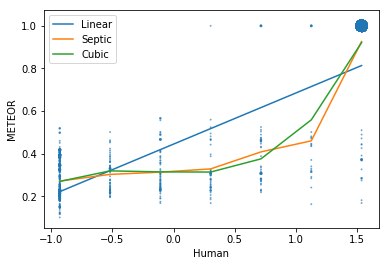

In [16]:
key = "METEOR"
scatter_plot(final_actions, metric_action_scores[key], xlabel="Human", ylabel=key[0].upper() + key[1:])

/home/waseem/venvs/ptcap/lib/python3.5/site-packages/ipykernel_launcher.py:53: RankWarning: Polyfit may be poorly conditioned


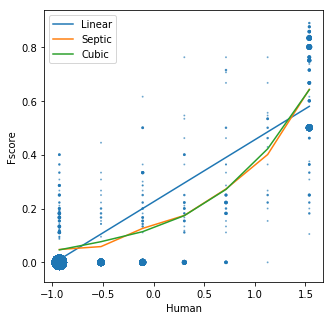

In [17]:
key = "fscore"
scatter_plot(final_actions, metric_action_scores[key], xlabel="Human", ylabel=key[0].upper() + key[1:])

/home/waseem/venvs/ptcap/lib/python3.5/site-packages/ipykernel_launcher.py:53: RankWarning: Polyfit may be poorly conditioned


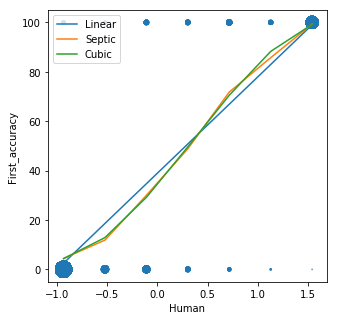

In [18]:
key = "first_accuracy"
scatter_plot(final_actions, metric_action_scores[key], xlabel="Human", ylabel=key[0].upper() + key[1:])

/home/waseem/venvs/ptcap/lib/python3.5/site-packages/ipykernel_launcher.py:53: RankWarning: Polyfit may be poorly conditioned


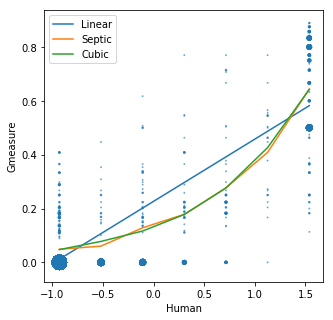

In [19]:
key = "gmeasure"
scatter_plot(final_actions, metric_action_scores[key], xlabel="Human", ylabel=key[0].upper() + key[1:])

In [20]:
def extract_objects(captions, templates):
    objects_list = []
    for cap, temp in zip(captions, templates):
        objects = get_objects(cap.split(), temp.split())
        objects_list.append(" ".join(objects))
    return objects_list


def get_objects(caption, template):
    return [token for token in caption if token not in template and token not in stop_words]

In [ ]:
get_objects(sentences1[0].split(), sentence1_templates[0].split())

In [ ]:
start = 100
end = 101
extract_objects(sentences1[start:end], sentence1_templates[start:end])

In [ ]:
sentences1[:10]

In [31]:
sentence1_objects = extract_objects(sentences1, sentence1_templates)
sentence2_objects = extract_objects(sentences2, sentence2_templates)

In [32]:
sentence1_objects_clean = [s for i,s in enumerate(sentence1_objects) if len(s) != 0 and len(sentence2_objects[i]) != 0]
sentence2_objects_clean = [s for i,s in enumerate(sentence2_objects) if len(s) != 0 and len(sentence1_objects[i]) != 0]

In [33]:
object_indices = [i for i,s in enumerate(sentence1_objects) if len(s) != 0 and len(sentence2_objects[i]) != 0]

In [34]:
len(object_indices)

644

In [ ]:
metric_object_scores = try_metrics(sentence1_objects_clean, sentence2_objects_clean)

In [ ]:
with open("/home/waseem/Metrics Analysis/metric_object_scores", "w") as f:
    json.dump(metric_object_scores, f)

In [35]:
with open("/home/waseem/Metrics Analysis/metric_object_scores", "r") as f:
    metric_object_scores = json.load(f)

In [36]:
final_objects_clean = [final_objects[i] for i in object_indices]

In [37]:
len(metric_object_scores["SPICE"])

644

In [ ]:
len(final_objects_clean)

In [ ]:
get_correlations(metric_object_scores, final_objects_clean, correlation_metrics)

In [ ]:
metrics_df = pd.DataFrame(data=get_correlations(metric_object_scores, final_objects_clean, correlation_metrics))
metrics_df.to_csv("/home/waseem/Metrics Analysis/metric_object_scores.csv")

In [ ]:
metrics_df = pd.DataFrame(data=get_correlations(metric_action_scores, final_actions, correlation_metrics))
metrics_df.to_csv("/home/waseem/Metrics Analysis/metric_action_scores.csv")

In [38]:
key = "SPICE"
comparison = final_score
k = 4
bins = split_into_bins(output_dict[key], k)
for bin_name, bin_list in sorted(bins.items())[::-1]:
    gt = [output_dict[key][i] for i in bin_list]
    scores = [comparison[i] for i in bin_list]
    print("{}: {}".format(bin_name, get_correlations(scores, gt, correlation_metrics)["Spearman"]))

bin_4: 0.17992709970462212
bin_3: 0.06120383390783654
bin_2: 0.35277251091532935
bin_1: 0.1605997750142448


In [39]:
key = "first_accuracy"
metric_dict = metric_object_scores
comparison = final_objects_clean
k = 1
bins = split_into_bins(metric_dict[key], k)
for bin_name, bin_list in sorted(bins.items())[::-1]:
    gt = [metric_dict[key][i] for i in bin_list]
    scores = [comparison[i] for i in bin_list]
    print("{}: {}".format(bin_name, get_correlations(scores, gt, correlation_metrics)["Spearman"]))

bin_1: 0.5464963786281757


In [40]:
key = "accuracy"
metric_dict = metric_action_scores
comparison = final_actions
k = 4
bins = split_into_bins(metric_dict[key], k)
for bin_name, bin_list in sorted(bins.items())[::-1]:
    gt = [metric_dict[key][i] for i in bin_list]
    scores = [comparison[i] for i in bin_list]
    print("{}: {}".format(bin_name, get_correlations(scores, gt, correlation_metrics)["Spearman"]))

bin_4: 0.8989203056894643
bin_3: -0.032131292242516055
bin_2: 0.15717526391244208
bin_1: 0.12957121533373828


bin_1: 0.7856311582221892


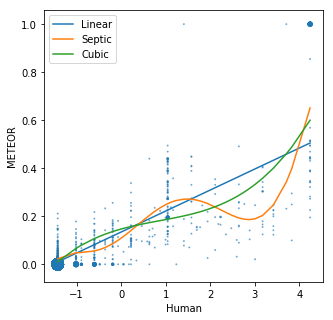

bin_1: 0.740072364867474


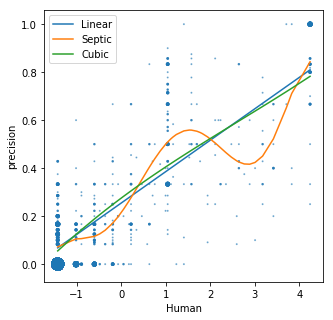

bin_1: 0.6051815342420112


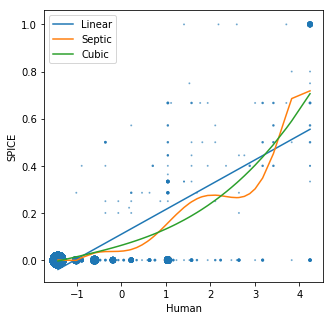

In [41]:
key = "METEOR"
metric_dict = output_dict
comparison = final_score
k = 1
for key in ["METEOR", "precision", "SPICE"]:
    bins = split_into_bins(metric_dict[key], k)
    for bin_name, bin_list in sorted(bins.items())[::-1]:
        gt = [metric_dict[key][i] for i in bin_list]
        scores = [comparison[i] for i in bin_list]
        print("{}: {}".format(bin_name, get_correlations(scores, gt, correlation_metrics)["Spearman"]))
        scatter_plot(scores, gt, "Human", key)

bin_1: 0.6051815342420112


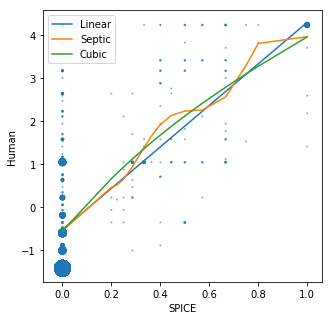

In [42]:
key = "SPICE"
metric_dict = output_dict
comparison = final_score
k = 1
bins = split_into_bins(metric_dict[key], k)
for bin_name, bin_list in sorted(bins.items())[::-1]:
    gt = [metric_dict[key][i] for i in bin_list]
    scores = [comparison[i] for i in bin_list]
    print("{}: {}".format(bin_name, get_correlations(scores, gt, correlation_metrics)["Spearman"]))
    scatter_plot(gt, scores, key, "Human")

bin_1: 0.5474698536869753


/home/waseem/venvs/ptcap/lib/python3.5/site-packages/ipykernel_launcher.py:53: RankWarning: Polyfit may be poorly conditioned


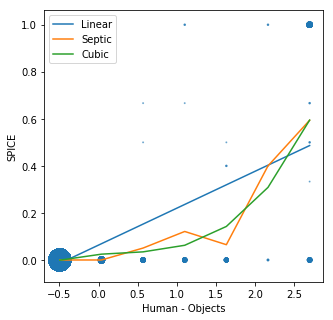

In [43]:
key = "SPICE"
metric_dict = metric_object_scores
comparison = final_objects_clean
k = 1
bins = split_into_bins(metric_dict[key], k)
for bin_name, bin_list in sorted(bins.items())[::-1]:
    gt = [metric_dict[key][i] for i in bin_list]
    scores = [comparison[i] for i in bin_list]
    print("{}: {}".format(bin_name, get_correlations(scores, gt, correlation_metrics)["Spearman"]))
    scatter_plot(scores, gt, "Human - Objects", key)

bin_1: 0.755782690665481


/home/waseem/venvs/ptcap/lib/python3.5/site-packages/ipykernel_launcher.py:53: RankWarning: Polyfit may be poorly conditioned


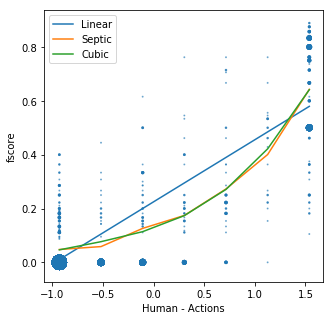

In [44]:
key = "fscore"
metric_dict = metric_action_scores
comparison = final_actions
k = 1
bins = split_into_bins(metric_dict[key], k)
for bin_name, bin_list in sorted(bins.items())[::-1]:
    gt = [metric_dict[key][i] for i in bin_list]
    scores = [comparison[i] for i in bin_list]
    print("{}: {}".format(bin_name, get_correlations(scores, gt, correlation_metrics)["Spearman"]))
    scatter_plot(scores, gt, "Human - Actions", key)

In [50]:
polybasis = lambda x, p: PolynomialFeatures(p).fit_transform(x)

In [122]:
key = "first_accuracy"
metric_score = np.reshape(np.array(output_dict[key]), [-1, 1])
comparison = np.reshape(np.array(final_score), [-1, 1])

lml = list()
for d in range(13):
    blm = BayesianLinearModel(basis=lambda x: polybasis(x, d))
    blm.update(comparison, metric_score)
    lml.append(blm.evidence())
    
D = np.argmax(lml)
print("Best polynomial order: {}".format(D))
blm = BayesianLinearModel(basis=lambda x: polybasis(x, D))
blm.update(comparison, metric_score)
mu, S2, lik = blm.predict(comparison, y=metric_score, variance=True)

Best polynomial order: 5


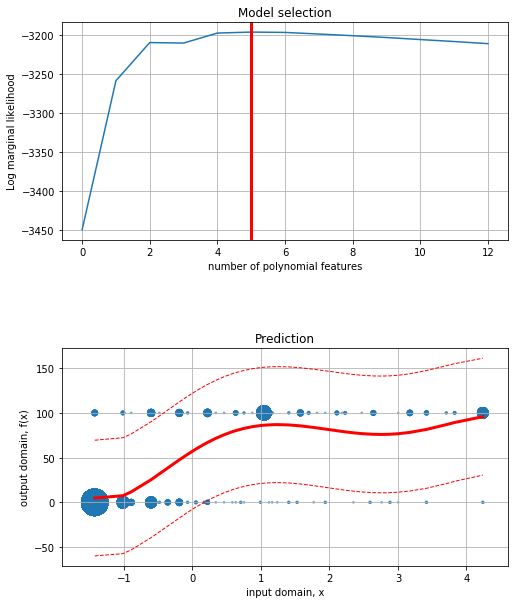

In [123]:
# Plot model selection.
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))
f.subplots_adjust(hspace=0.5)
ax1.plot(range(len(lml)), lml)
ax1.set_title('Model selection')
ax1.set_xlabel('number of polynomial features')
ax1.set_ylabel('Log marginal likelihood')
ax1.axvline(D, color='r', linewidth='3')
ax1.grid('on')

from matplotlib import cm

x_query = comparison

# Plot model predictions.
a, b = zip(*sorted(zip(x_query, mu + S2)))
c, d = zip(*sorted(zip(x_query, mu)))
e, f = zip(*sorted(zip(x_query, mu - S2)))
x, y = zip(*sorted(zip(final_score, output_dict[key])))

agg_all = Counter(zip(x, y))
z = []
for x_, y_ in zip(x, y):
    z.append(3*agg_all[x_, y_])

plt.plot(a, b, 'r--', linewidth=1)
plt.plot(c, d, 'r', linewidth=3)
plt.plot(e, f, 'r--', linewidth=1)
plt.scatter(x, y, s=z, alpha=0.5)
ax2.set_title('Prediction')
ax2.set_xlabel('input domain, x')
ax2.set_ylabel('output domain, f(x)')
ax2.grid('on')
plt.show()

Best polynomial order: 1
S2: 0.4916436121424763


TypeError: unhashable type: 'numpy.ndarray'

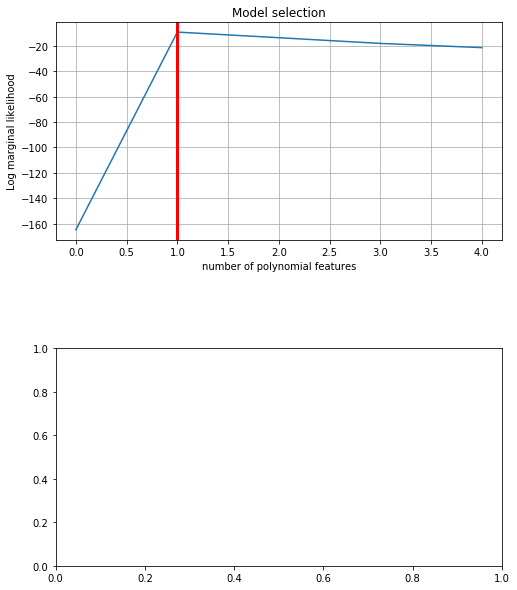

In [148]:
key = "first_accuracy" 
final_sscore = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
sscore = np.array(final_sscore) + np.random.randn(*final_sscore.shape)

extend_ = 4*np.ones([100])

train_final_sscore = np.reshape(np.concatenate([final_sscore, extend_], axis=0), [-1,1])
train_sscore = np.reshape(np.concatenate([sscore, extend_], axis=0), [-1,1])

metric_score = np.reshape(np.array(sscore), [-1, 1])
comparison = np.reshape(np.array(final_sscore), [-1, 1])

lml = list()
for d in range(5):
    blm = BayesianLinearModel(basis=lambda x: polybasis(x, d))
    blm.update(train_final_sscore, train_sscore)
    lml.append(blm.evidence())
    
D = np.argmax(lml)
print("Best polynomial order: {}".format(D))
blm = BayesianLinearModel(basis=lambda x: polybasis(x, D))
blm.update(train_final_sscore, train_sscore)
mu, S2, lik = blm.predict(train_final_sscore, y=train_sscore, variance=True)

print("S2: {}".format(np.mean(S2)))

# Plot model selection.
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))
f.subplots_adjust(hspace=0.5)
ax1.plot(range(len(lml)), lml)
ax1.set_title('Model selection')
ax1.set_xlabel('number of polynomial features')
ax1.set_ylabel('Log marginal likelihood')
ax1.axvline(D, color='r', linewidth='3')
ax1.grid('on')

from matplotlib import cm

x_query = comparison

# Plot model predictions.
a, b = zip(*sorted(zip(x_query, mu + S2)))
c, d = zip(*sorted(zip(x_query, mu)))
e, f = zip(*sorted(zip(x_query, mu - S2)))
x, y = zip(*sorted(zip(train_final_sscore, train_sscore)))

agg_all = Counter(zip(x, y))
z = []
for x_, y_ in zip(x, y):
    z.append(3*agg_all[x_, y_])

plt.plot(a, b, 'r--', linewidth=1)
plt.plot(c, d, 'r', linewidth=3)
plt.plot(e, f, 'r--', linewidth=1)
plt.scatter(x, y, s=z, alpha=0.5)
ax2.set_title('Prediction')
ax2.set_xlabel('input domain, x')
ax2.set_ylabel('output domain, f(x)')
ax2.grid('on')
plt.show()

In [144]:
np.concatenate([final_sscore, 4*np.ones([10])], axis=0)

array([  1. ,   2. ,   3. ,   3.1,   3.2,   3.3,   5. ,   6. ,   7. ,
         8. ,   9. ,  10. ,   4. ,   4. ,   4. ,   4. ,   4. ,   4. ,
         4. ,   4. ,   4. ,   4. ])

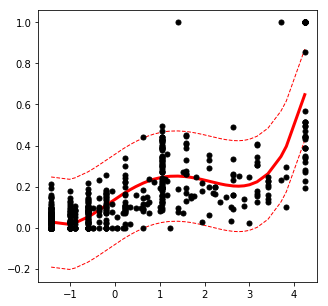

In [106]:
a, b = zip(*sorted(zip(x_query, mu + S2)))
c, d = zip(*sorted(zip(x_query, mu)))
e, f = zip(*sorted(zip(x_query, mu - S2)))
g, h = zip(*sorted(zip(comparison, metric_score)))

plt.plot(a, b, 'r--', linewidth=1)
plt.plot(c, d, 'r', linewidth=3)
plt.plot(e, f, 'r--', linewidth=1)
plt.plot(g, h, 'k.', markersize=10)

bin_1: 0.7856311582221892


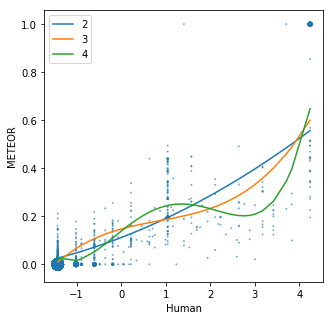

In [107]:
key = "METEOR"
metric_score = output_dict[key]
comparison = final_score
k = 1
bins = split_into_bins(metric_dict[key], k)
for bin_name, bin_list in sorted(bins.items())[::-1]:
    gt = [metric_score[i] for i in bin_list]
    scores = [comparison[i] for i in bin_list]
    print("{}: {}".format(bin_name, get_correlations(scores, gt, correlation_metrics)["Spearman"]))
    scatter_plot(scores, gt, "Human", key, [2, 3, 4])